In [220]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [221]:
stock = yf.Ticker("BTC-USD") #XRP-USD
data = stock.history(period="2mo", interval="1d")
data = data.dropna()
data = data[["Close"]]
print(data[["Close"]])
train_size = int(len(data) * 0.85)
train = data[:train_size]
test = data[train_size:]

                                  Close
Date                                   
2023-09-05 00:00:00+00:00  25779.982422
2023-09-06 00:00:00+00:00  25753.236328
2023-09-07 00:00:00+00:00  26240.195312
2023-09-08 00:00:00+00:00  25905.654297
2023-09-09 00:00:00+00:00  25895.677734
...                                 ...
2023-11-01 00:00:00+00:00  35437.253906
2023-11-02 00:00:00+00:00  34938.242188
2023-11-03 00:00:00+00:00  34732.324219
2023-11-04 00:00:00+00:00  35082.195312
2023-11-05 00:00:00+00:00  35057.121094

[62 rows x 1 columns]


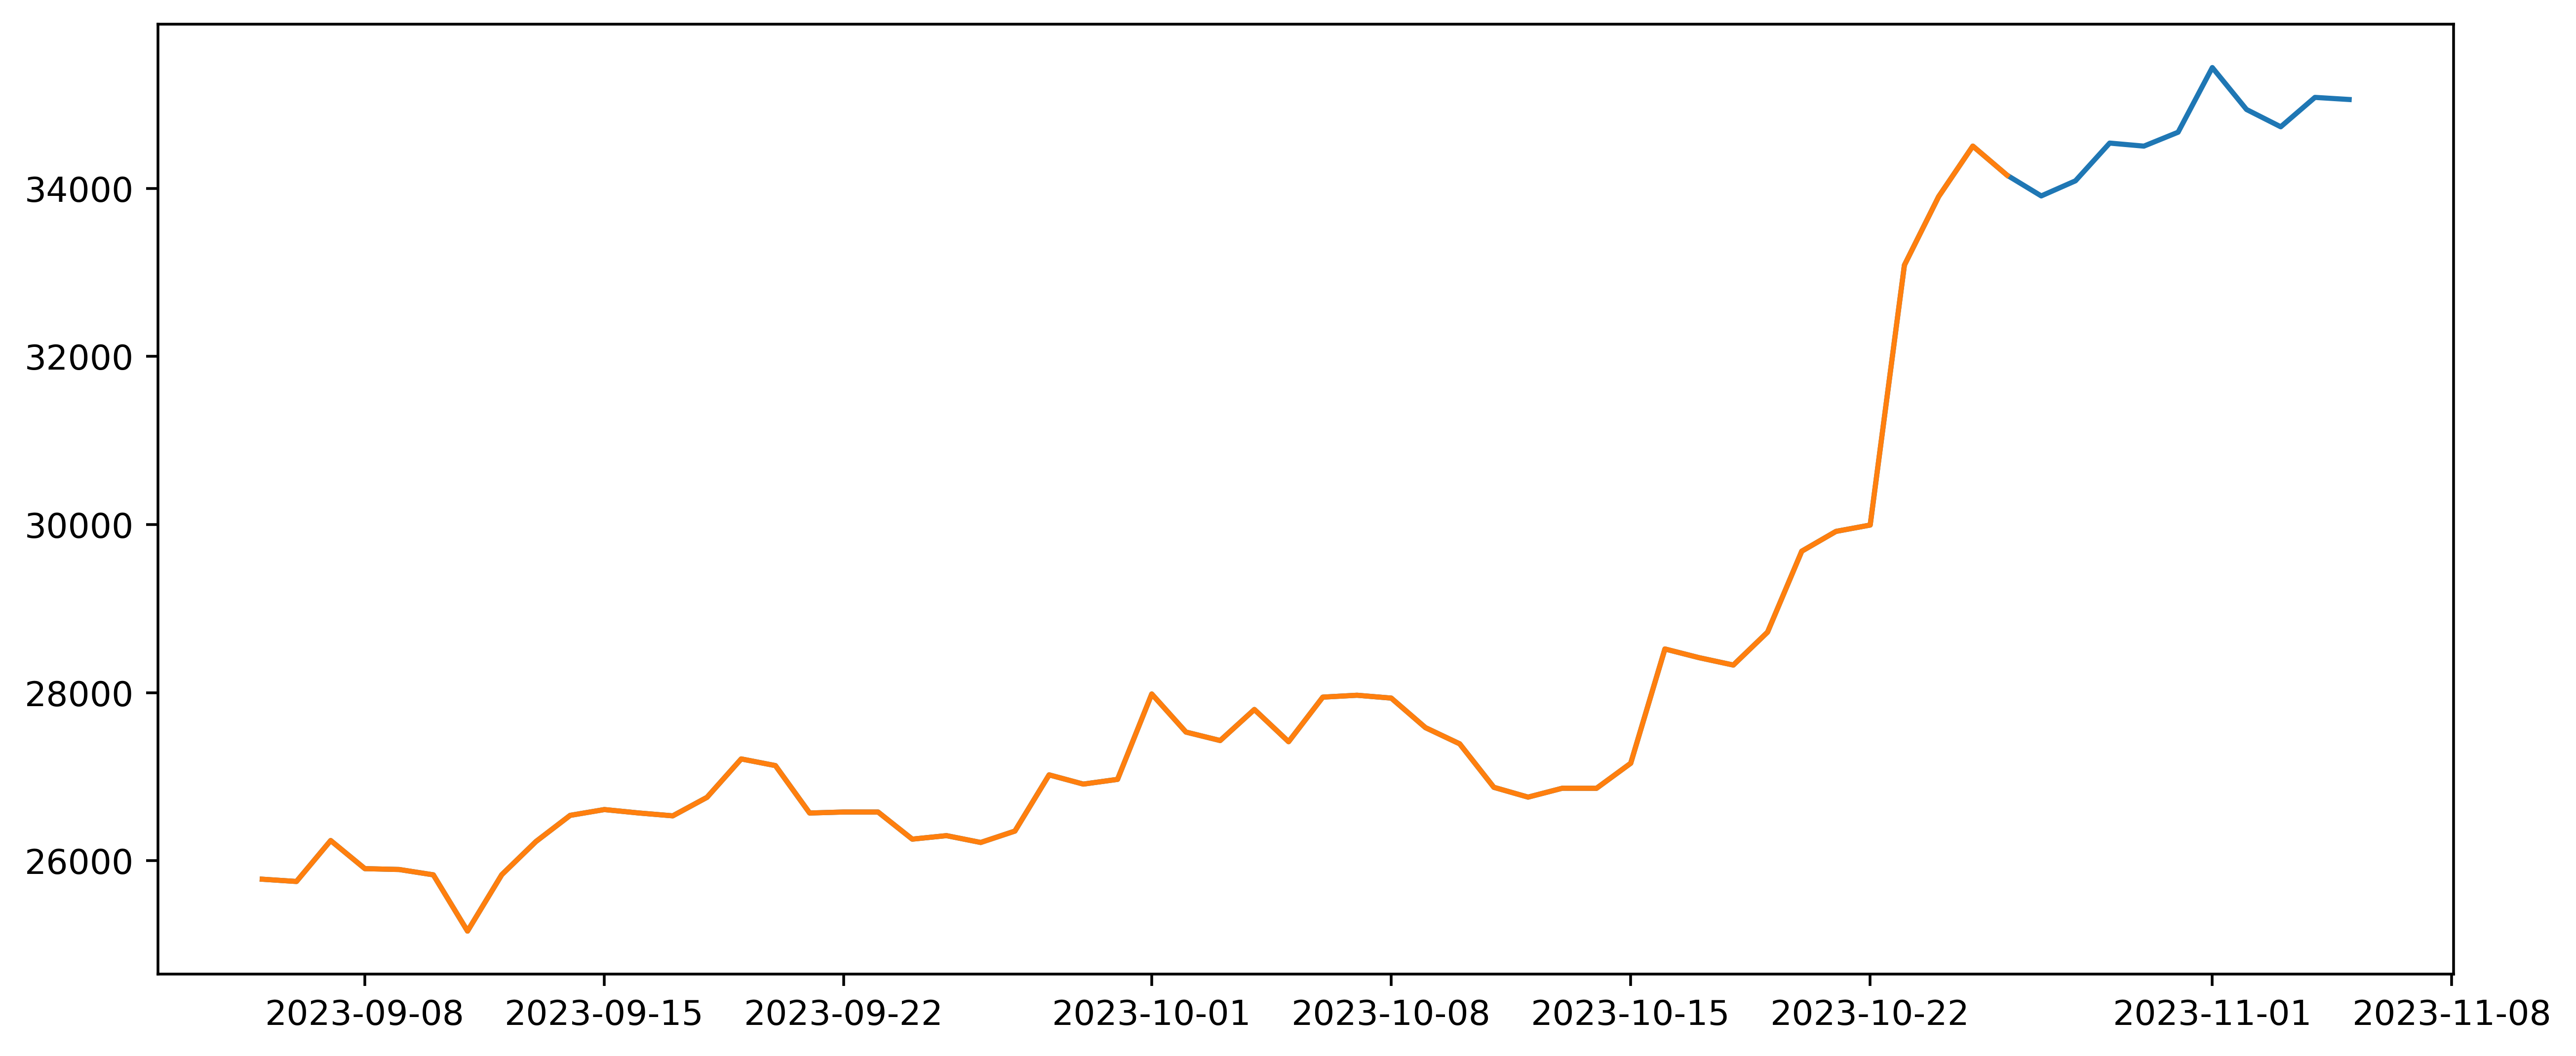

In [222]:
plt.figure(figsize=(12,5), dpi=500)
plt.plot(data[["Close"]])
plt.plot(train)


In [223]:
# print(data_log)
data_log_diff = data
#print(data_log_diff)
data_log_diff.reset_index(level=0, inplace=True, drop=True)
print(data_log_diff)

           Close
0   25779.982422
1   25753.236328
2   26240.195312
3   25905.654297
4   25895.677734
..           ...
57  35437.253906
58  34938.242188
59  34732.324219
60  35082.195312
61  35057.121094

[62 rows x 1 columns]


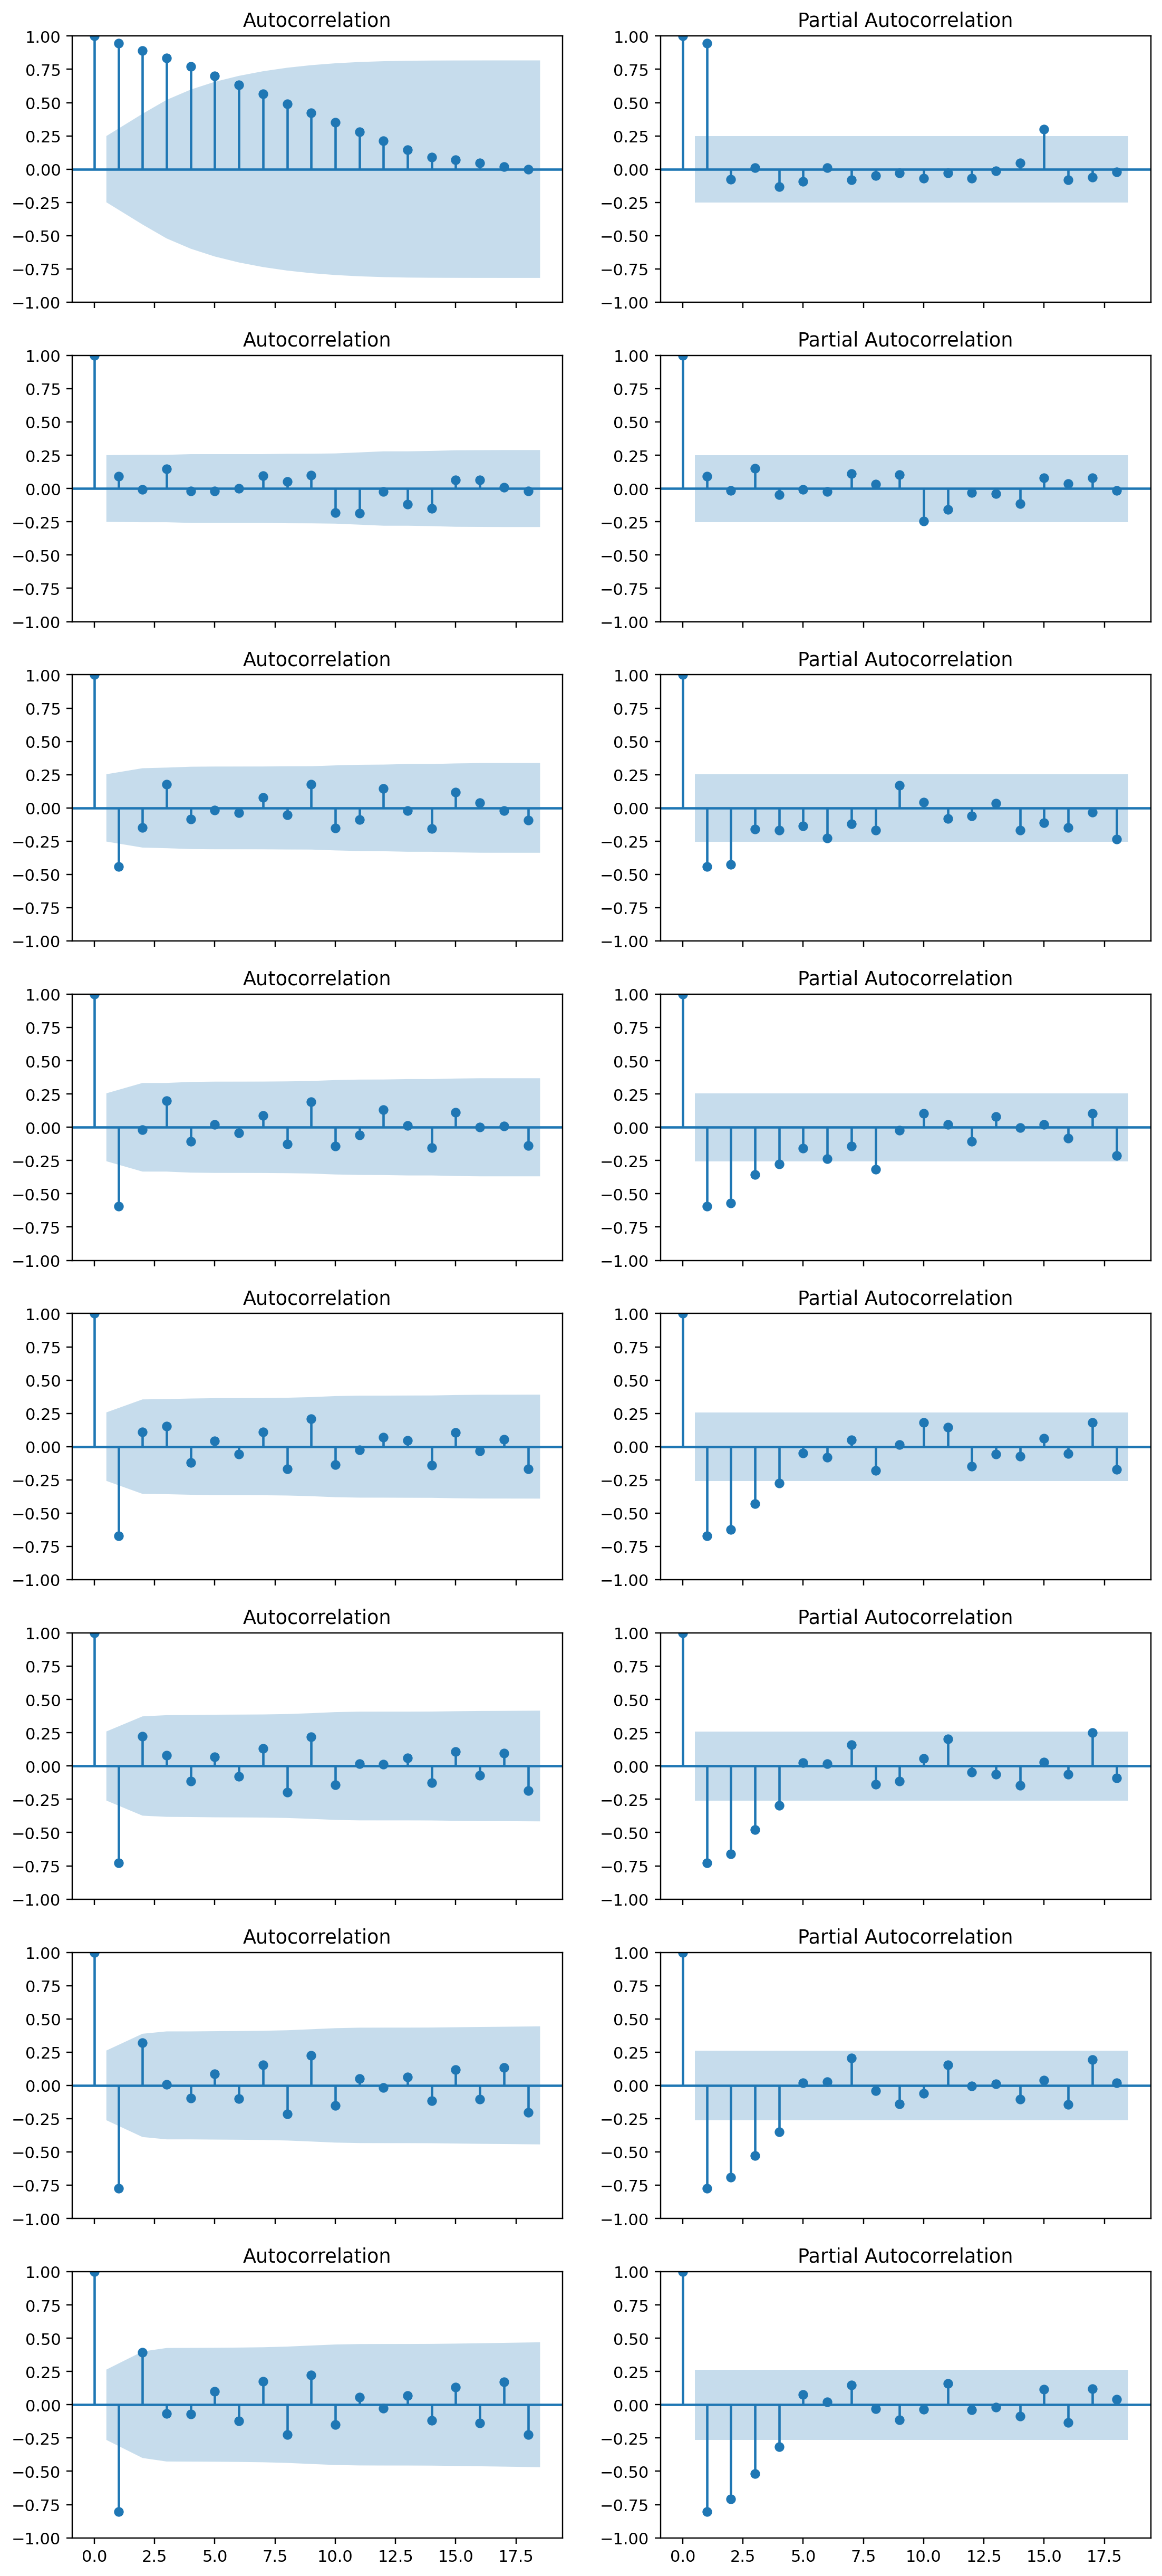

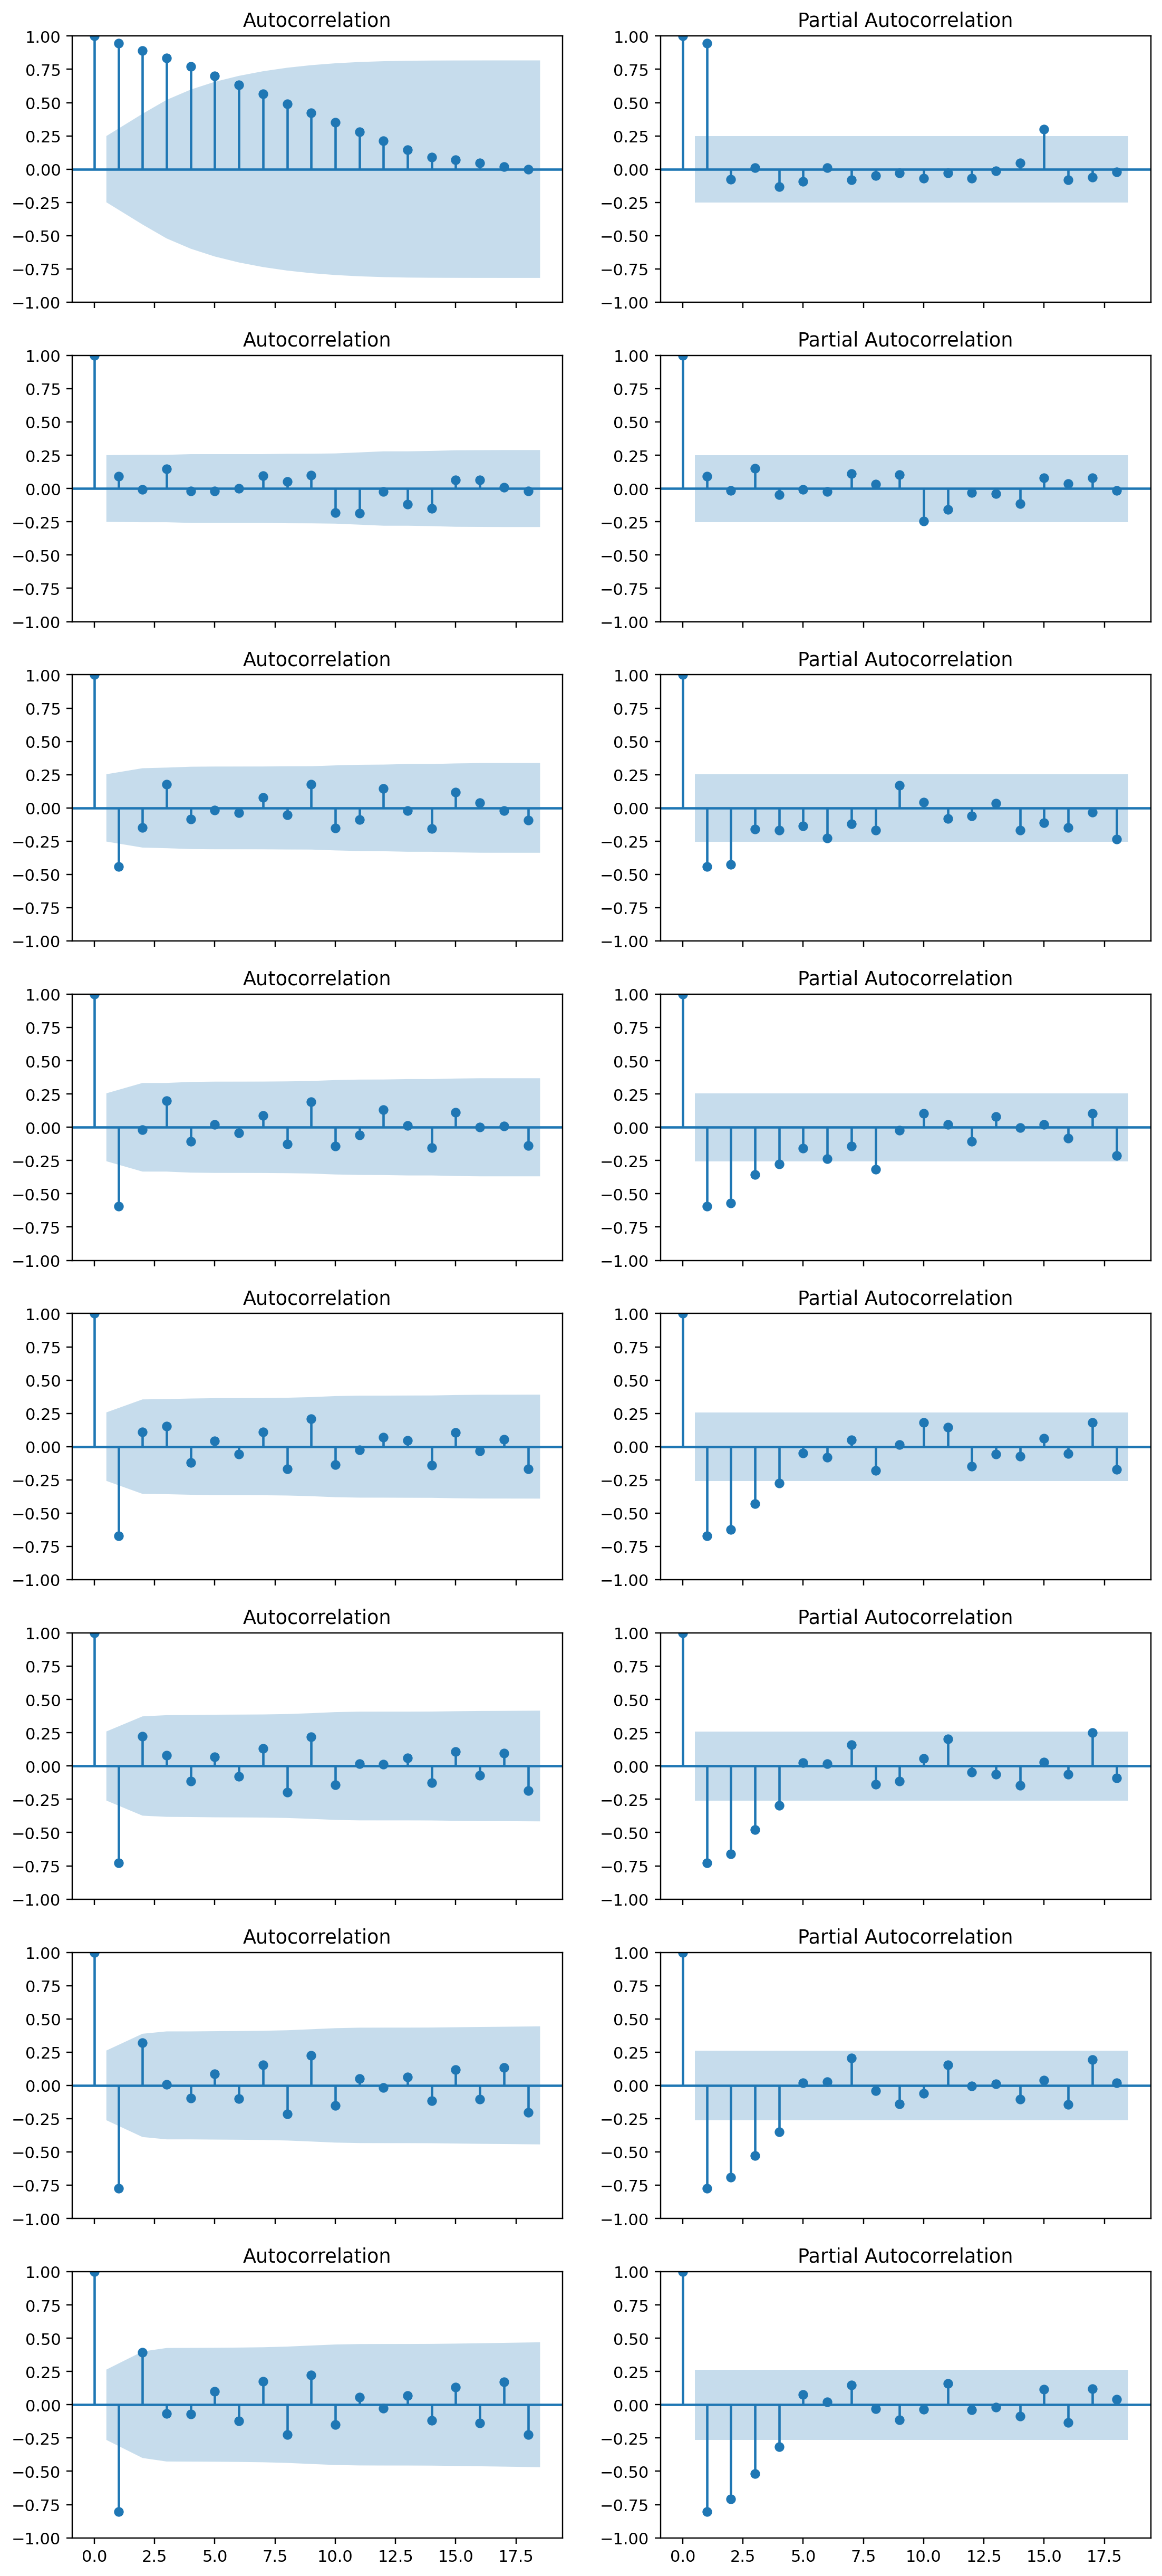

In [224]:
plt.rcParams.update({'figure.figsize':(12,28), 'figure.dpi':220})
fig, axes = plt.subplots(8, 2, sharex=True)
plot_acf(data_log_diff.dropna(), ax=axes[0, 0])
plot_pacf(data_log_diff.dropna(), ax=axes[0, 1])
plot_acf(data_log_diff.diff().dropna(), ax=axes[1, 0])
plot_pacf(data_log_diff.diff().dropna(), ax=axes[1, 1])
plot_acf(data_log_diff.diff().diff().dropna(), ax=axes[2, 0])
plot_pacf(data_log_diff.diff().diff().dropna(), ax=axes[2, 1])
plot_acf(data_log_diff.diff().diff().diff().dropna(), ax=axes[3, 0])
plot_pacf(data_log_diff.diff().diff().diff().dropna(), ax=axes[3, 1])
plot_acf(data_log_diff.diff().diff().diff().diff().dropna(), ax=axes[4, 0])
plot_pacf(data_log_diff.diff().diff().diff().diff().dropna(), ax=axes[4, 1])
plot_acf(data_log_diff.diff().diff().diff().diff().diff().dropna(), ax=axes[5, 0])
plot_pacf(data_log_diff.diff().diff().diff().diff().diff().dropna(), ax=axes[5, 1])
plot_acf(data_log_diff.diff().diff().diff().diff().diff().diff().dropna(), ax=axes[6, 0])
plot_pacf(data_log_diff.diff().diff().diff().diff().diff().diff().dropna(), ax=axes[6, 1])
plot_acf(data_log_diff.diff().diff().diff().diff().diff().diff().diff().dropna(), ax=axes[7, 0])
plot_pacf(data_log_diff.diff().diff().diff().diff().diff().diff().diff().dropna(), ax=axes[7, 1])

In [225]:
from statsmodels.tsa.stattools import adfuller
#interested 1, 2, 3, 4, 5, 6, 7
ls_0 = data_log_diff.dropna()
adf_test_0 = adfuller(ls_0) #1
print(f'p-value_0: {adf_test_0[1]}')

# adf_test_01 = len(str(adf_test_0))
# print(adf_test_01)
# if adf_test_01 >= 0.05:
#     print('no stationarity')

ls_1 = data_log_diff.diff().dropna()
adf_test_1 = adfuller(ls_1) #1
print(f'p-value_1: {adf_test_1[1]}')

ls_2 = data_log_diff.diff().diff().dropna()
adf_test_2 = adfuller(ls_2) #2
print(f'p-value_2: {adf_test_2[1]}')

ls_3 = data_log_diff.diff().diff().diff().dropna()
adf_test_3 = adfuller(ls_3) #3
print(f'p-value_3: {adf_test_3[1]}')

ls_4 = data_log_diff.diff().diff().diff().diff().dropna()
adf_test_4 = adfuller(ls_4) #4
print(f'p-value_4: {adf_test_4[1]}')

ls_5 = data_log_diff.diff().diff().diff().diff().diff().dropna()
#print(ls)
adf_test_5 = adfuller(ls_5) #5
print(f'p-value_5: {adf_test_5[1]}')

ls_6 = data_log_diff.diff().diff().diff().diff().diff().diff().dropna()
adf_test_6 = adfuller(ls_6) #6
print(f'p-value_6: {adf_test_6[1]}')

ls_7 = data_log_diff.diff().diff().diff().diff().diff().diff().diff().dropna()
adf_test_7 = adfuller(ls_7) #7
print(f'p-value_7: {adf_test_7[1]}')


p-value_0: 0.9833150544708481
p-value_1: 1.0247234547575547e-09
p-value_2: 2.884140558119162e-17
p-value_3: 1.4150731208954186e-06
p-value_4: 5.171615390520923e-06
p-value_5: 4.469573758879315e-07
p-value_6: 7.777220253972338e-07
p-value_7: 6.81055205066003e-07


In [226]:
best_aic = np.inf 
best_params = None 
seasonal_period = 5  # или любое другое значение, основанное на ваших данных

for p in range(3,10):
    for d in range(2,6):
        for q in range(0,3):
            for P in range(0,3):
                for D in range(0,3):
                    for Q in range(0,3):
                        try:
                            model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period))
                            model_fit = model.fit()
                            if model_fit.aic < best_aic:
                                best_aic = model_fit.aic
                                best_params = (p,d,q,P,D,Q)
                        except:  
                            continue

print("Best SARIMA model:", best_params, "AIC:", best_aic)
a = best_params

# model = SARIMAX(train, order=best_params[:3], seasonal_order=(best_params[3:]+(seasonal_period,)))
# model_fit = model.fit()
# print(model_fit.summary())

c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-p

In [ ]:
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_jb = np.inf 
best_params = None 
seasonal_period = 5  # или любое другое значение, основанное на ваших данных

for p in range(3,10):
    for d in range(2,6):
        for q in range(0,3):
            for P in range(0,3):
                for D in range(0,3):
                    for Q in range(0,3):
                        try:
                            model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period))
                            model_fit = model.fit()
                            jb = stats.jarque_bera(model_fit.resid)
                            if best_params is None or jb < best_jb:
                                best_jb = jb
                                best_params = (p,d,q,P,D,Q)
                        except:  
                            continue

print("Best SARIMA model:", best_params, "Jarque-Bera:", best_jb)
b = best_params

c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-p

Best SARIMA model: (3, 2, 1, 0, 2, 0) Jarque-Bera: Jarque_beraResult(statistic=301.68211561588646, pvalue=0.0)


c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
### вывод лучших параметров по двум циклам. Теперь нужно опробовать комбинации несколько комбинаций и определить лучшие
print(a, b)

(4, 2, 0, 0, 0, 0) (3, 2, 1, 0, 2, 0)


In [ ]:
# model = SARIMAX(train, order=(3, 2, 0,), seasonal_order=(best_params[3:]+(seasonal_period,)))
model = SARIMAX(train, order=(1,2,1), seasonal_order=(0, 2, 0, 5), enforce_stationarity=True)
model_fit = model.fit(enforce_stationarity=True)
print(model_fit.summary())

c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   52
Model:             SARIMAX(1, 2, 1)x(0, 2, [], 5)   Log Likelihood                  93.239
Date:                            Sun, 05 Nov 2023   AIC                           -180.478
Time:                                    17:30:12   BIC                           -175.412
Sample:                                09-05-2023   HQIC                          -178.646
                                     - 10-26-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2183      0.183     -1.191      0.233      -0.577       0.141
ma.L1         -0.9198      0.180   

c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


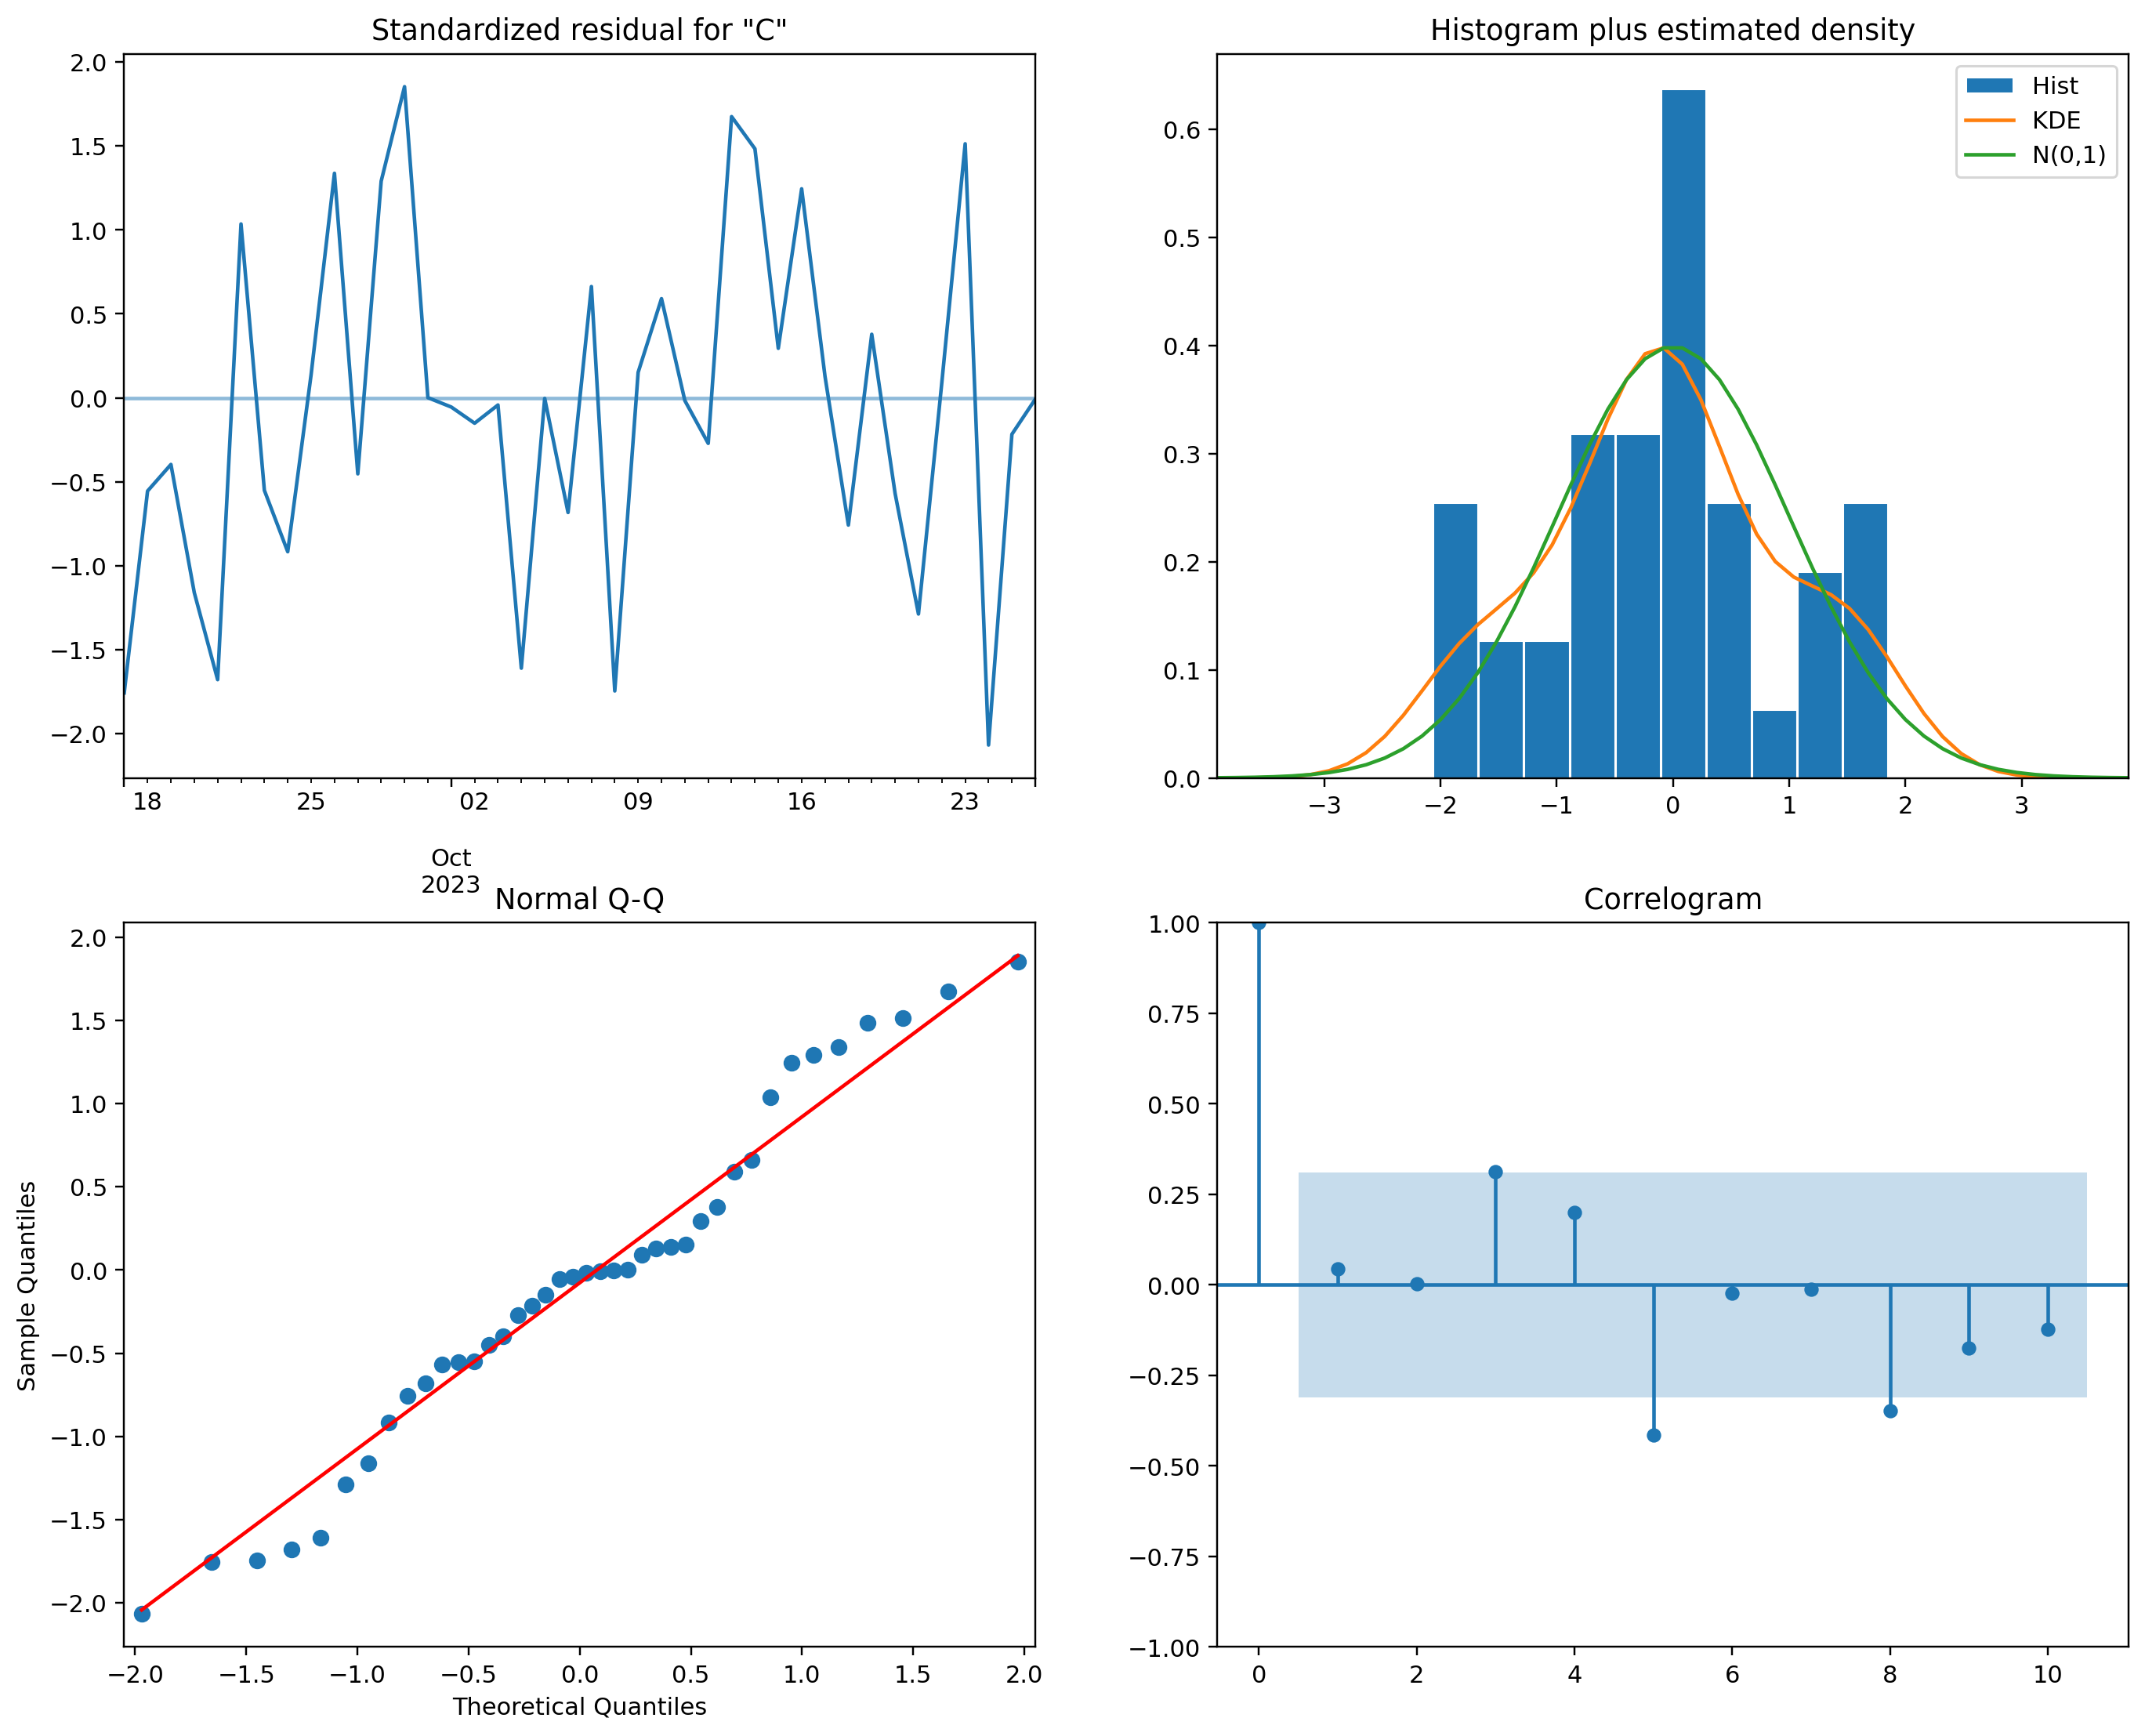

In [ ]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

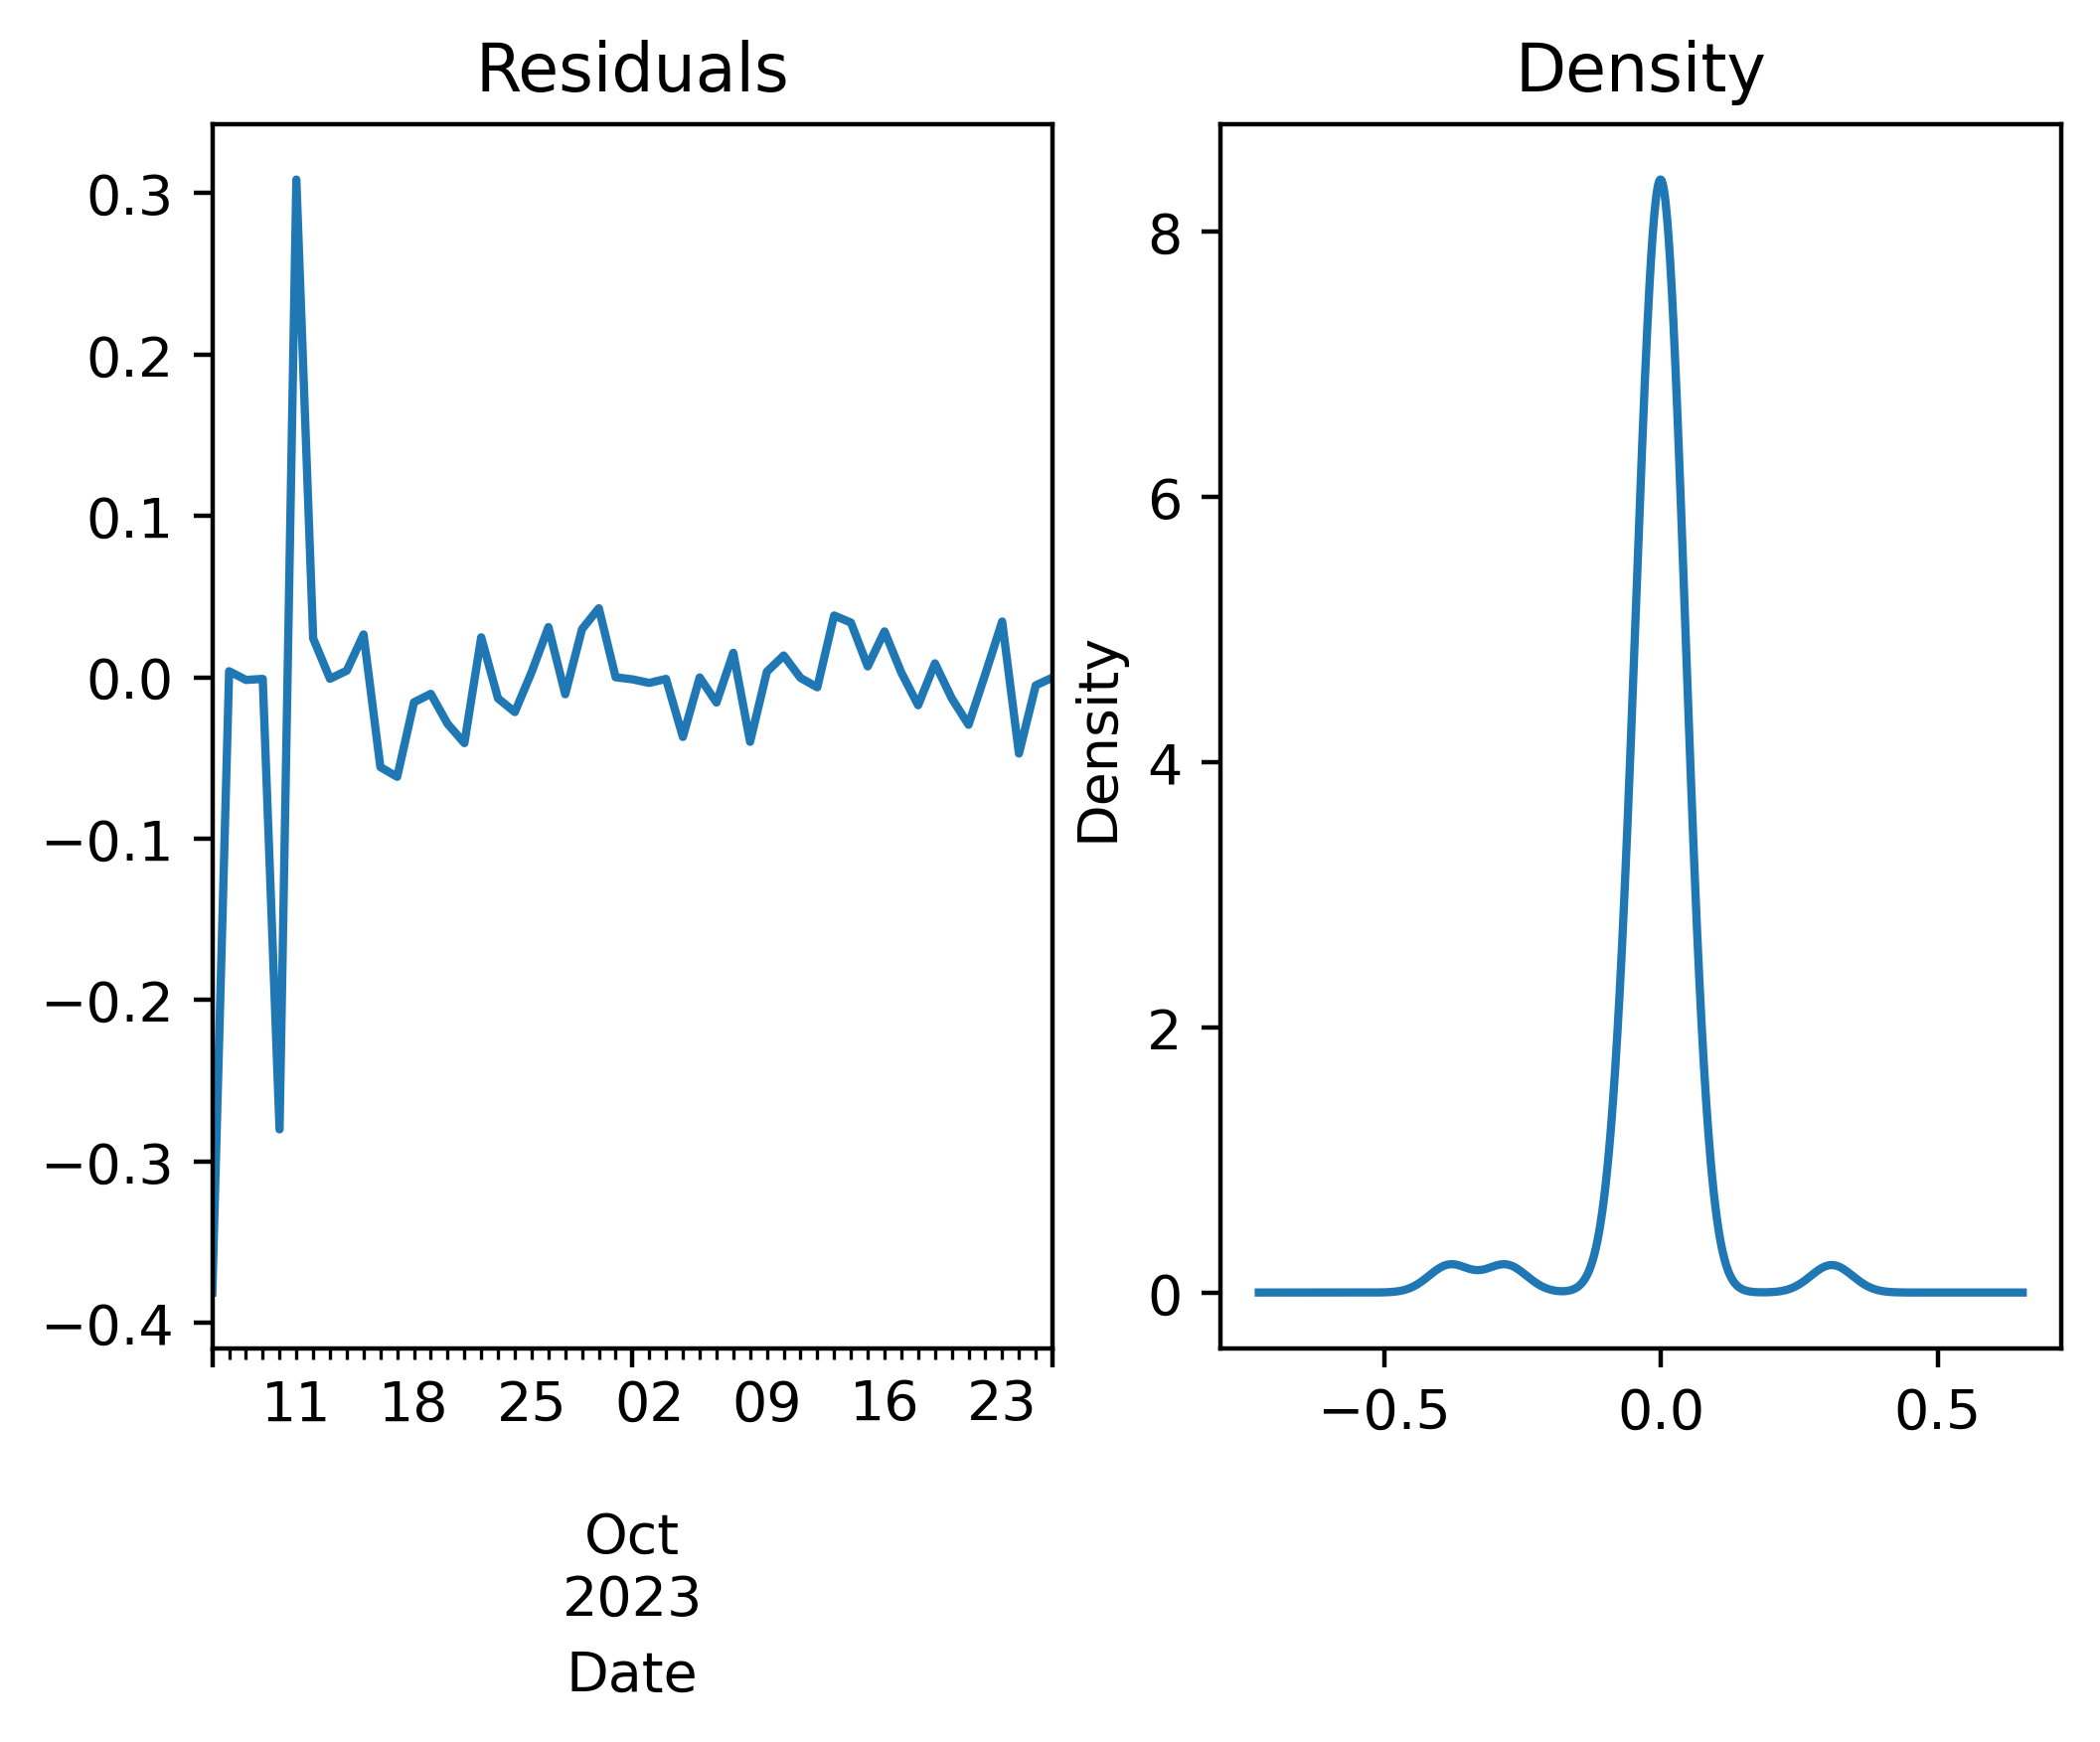

In [ ]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':400})
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

<Axes: >

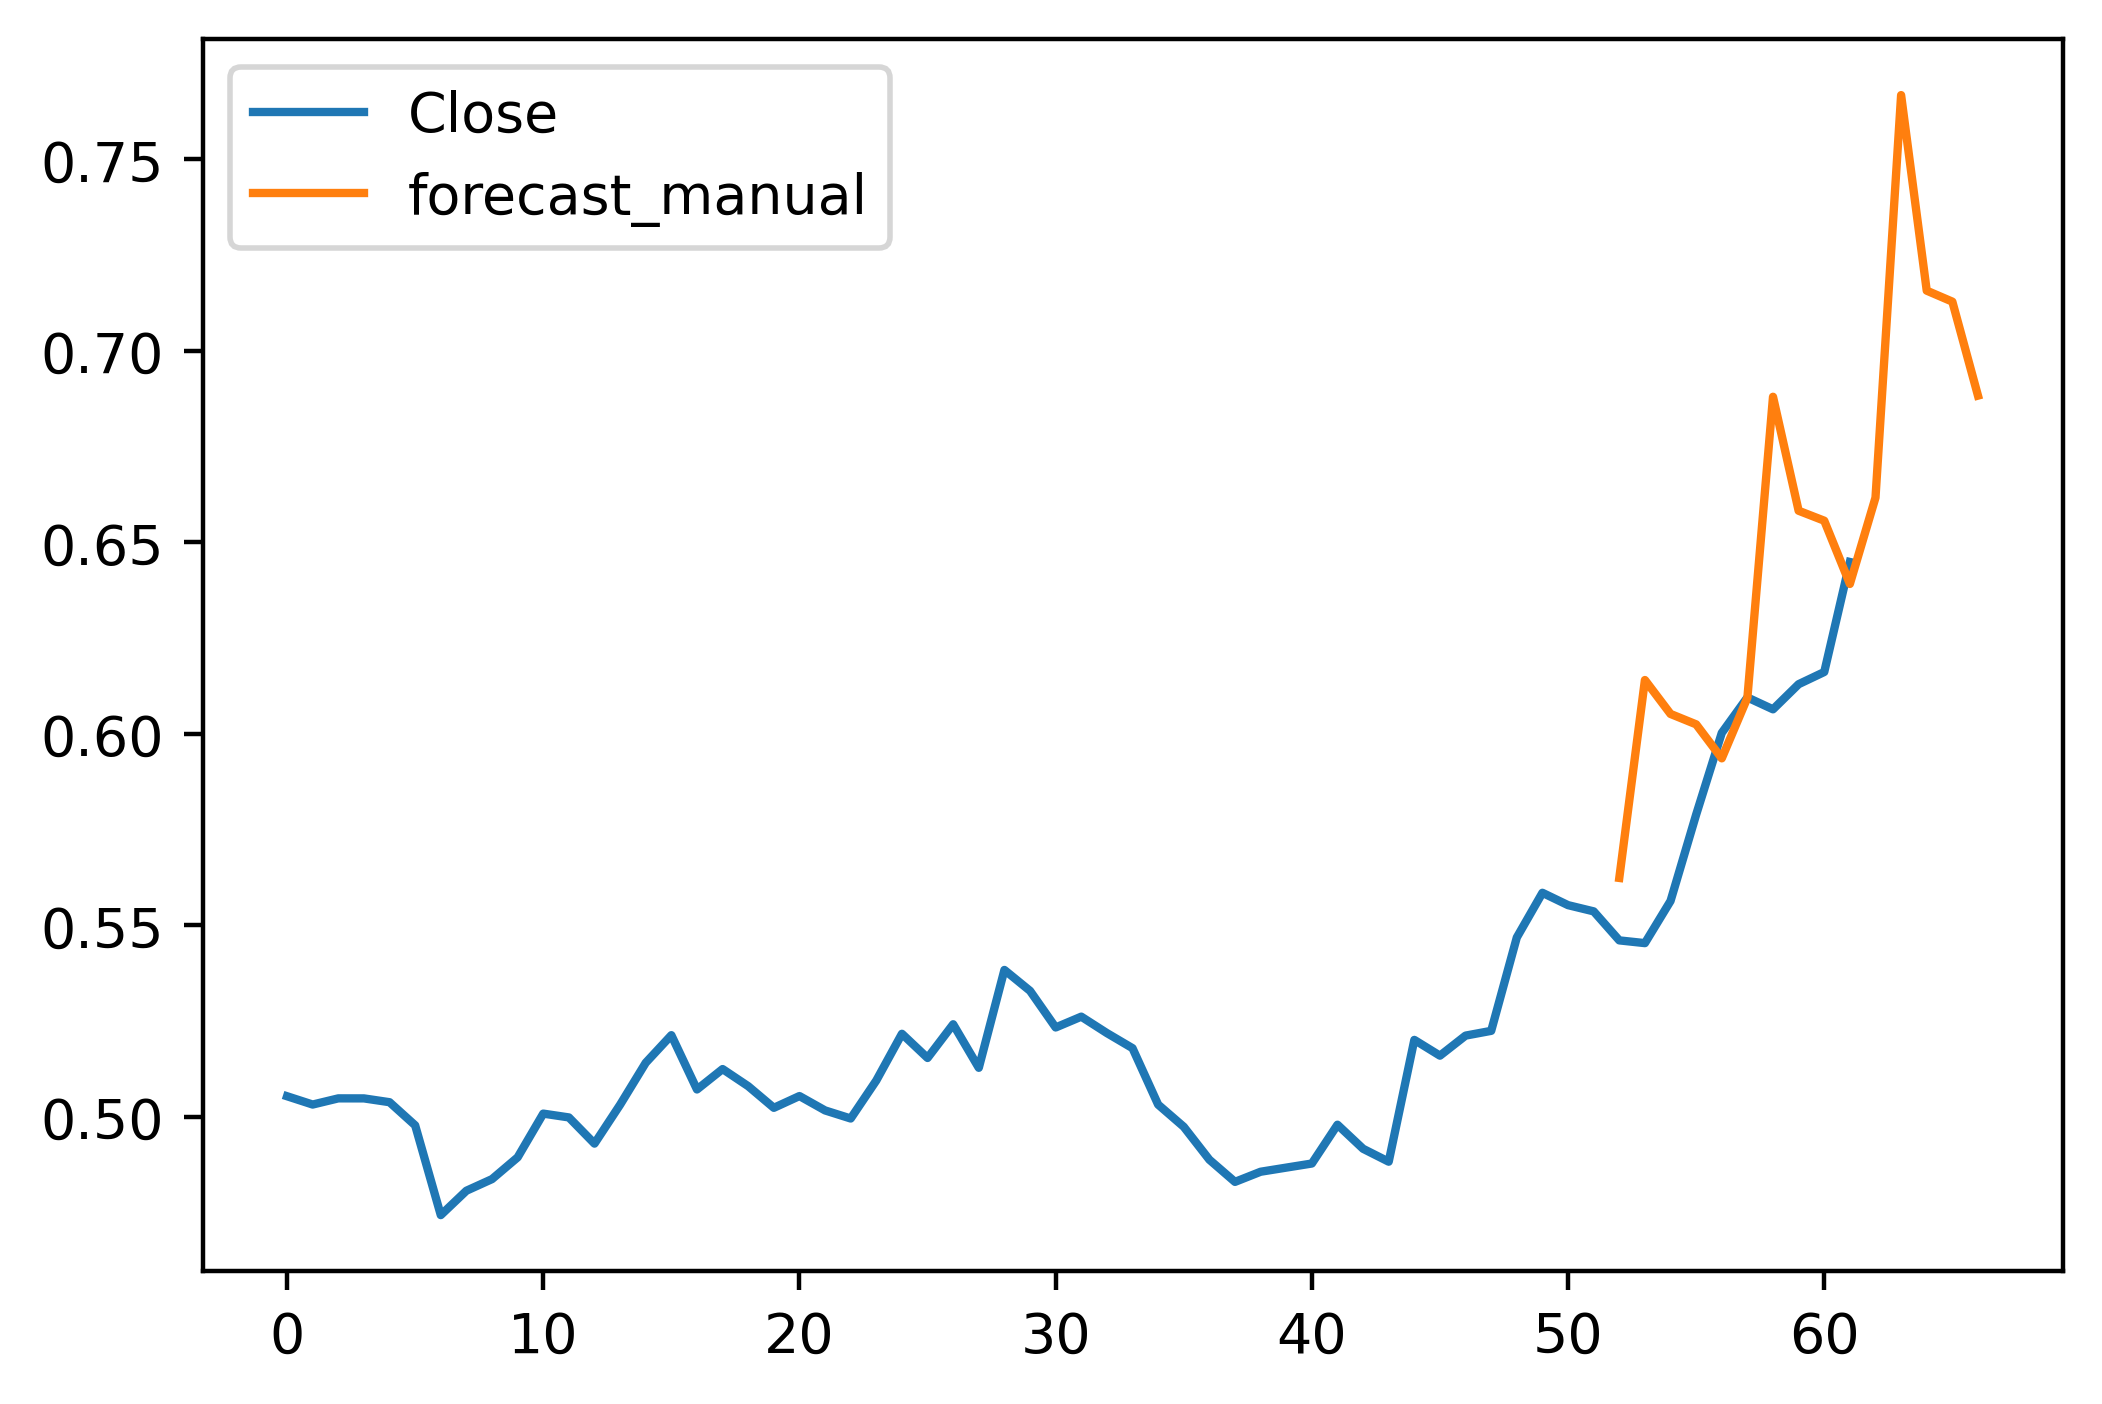

In [ ]:

# forecast_test = model_fit.forecast(len(test))

# data['forecast_manual'] = [None]*len(train) + list(forecast_test)
# # data_log['forecast_manual'] = np.expm1(data_log['forecast_manual'])
# # data_log = np.expm1(data_log)

# data.plot()

# Прогнозируем на 5 шагов вперед
forecast_test = model_fit.forecast(len(test) + 5)

# Создаем новый DataFrame для прогнозного периода
new_index = pd.date_range(data.index[-1], periods=6, freq='D')[1:] # предполагая, что ваш индекс - это даты
new_df = pd.DataFrame(index=new_index, columns=data.columns)

# Объединяем исходный и новый DataFrames
extended_data = pd.concat([data, new_df])

# Создаем столбец 'forecast_manual'
extended_data['forecast_manual'] = np.nan

# Заполняем прогнозные значения
extended_data['forecast_manual'].iloc[len(train):] = forecast_test

# Рисуем график
extended_data.plot()

In [ ]:
returns = data.Close.pct_change().dropna()
print(returns)

1    -0.004290
2     0.003207
3    -0.000014
4    -0.001971
5    -0.011990
        ...   
57    0.015419
58   -0.005084
59    0.010822
60    0.005191
61    0.046621
Name: Close, Length: 61, dtype: float64


In [ ]:
#Построение SARIMA модели для GARCH.
#Подбор оптимальных параметров p, d, q, P, D, Q с помощью информационного критерия Акаике (AIC) теста ХБ я сделал до этого, поэтому используем те данные 
arima_model_2 = SARIMAX(train, order=(1,2,1), seasonal_order=(0, 2, 0, 5))
arima_model_2_fit = arima_model_2.fit()

c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
best_aic_garch = np.inf
best_order_garch = None

In [ ]:
for i in range(5):
	for j in range(5):
		try:
			# Создание и обучение модели GARCH с заданными параметрами и остатками ARIMA модели в качестве входных данных
			model = arch_model(arima_model_2_fit.resid, mean="Zero", vol="GARCH", p=i, q=j)
			model_fit_garch = model.fit(disp="off")
			# Получение значения AIC для модели
			aic = model_fit_garch.aic
			# Сохранение лучшей модели, порядка и AIC
			if aic < best_aic:
				best_aic_garch = aic
				best_order_garch = (i,j)
				best_garch = model_fit_garch
		except:
			continue

print("Best GARCH model:", best_order_garch, "AIC:", best_aic_garch, "Copy CARCH model:", model_fit_garch)
best_garch = model_fit_garch
forecasts = best_garch.forecast(horizon=10) #Проноз на 1 день
variance = forecasts.variance.iloc[-1][0]
std_dev = np.sqrt(variance)


c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Егор\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Егор\AppData\Lo

Best GARCH model: None AIC: inf Copy CARCH model:                        Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.019
Vol Model:                      GARCH   Log-Likelihood:                97.5225
Distribution:                  Normal   AIC:                          -177.045
Method:            Maximum Likelihood   BIC:                          -159.484
                                        No. Observations:                   52
Date:                Sun, Nov 05 2023   Df Residuals:                       52
Time:                        17:30:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega   

In [ ]:
print(std_dev)

0.01783519917718626


In [ ]:
forecasts = best_garch.forecast(horizon=5, method='simulation', simulations=3000)
sims = forecasts.simulations


[[-0.00636472 -0.02697443 -0.00608942 ...  0.00067358 -0.00546402
   0.00177217]
 [-0.02210444  0.02261724 -0.00807104 ... -0.03348187  0.00757577
  -0.00443056]
 [-0.00476568  0.01516535  0.01158983 ... -0.0645048  -0.01894453
  -0.02594692]
 [ 0.00826128  0.00684031 -0.01973415 ... -0.00779758 -0.01720076
   0.02409294]
 [ 0.00690042 -0.00612893 -0.00431235 ...  0.00592492  0.03796494
   0.00146444]]


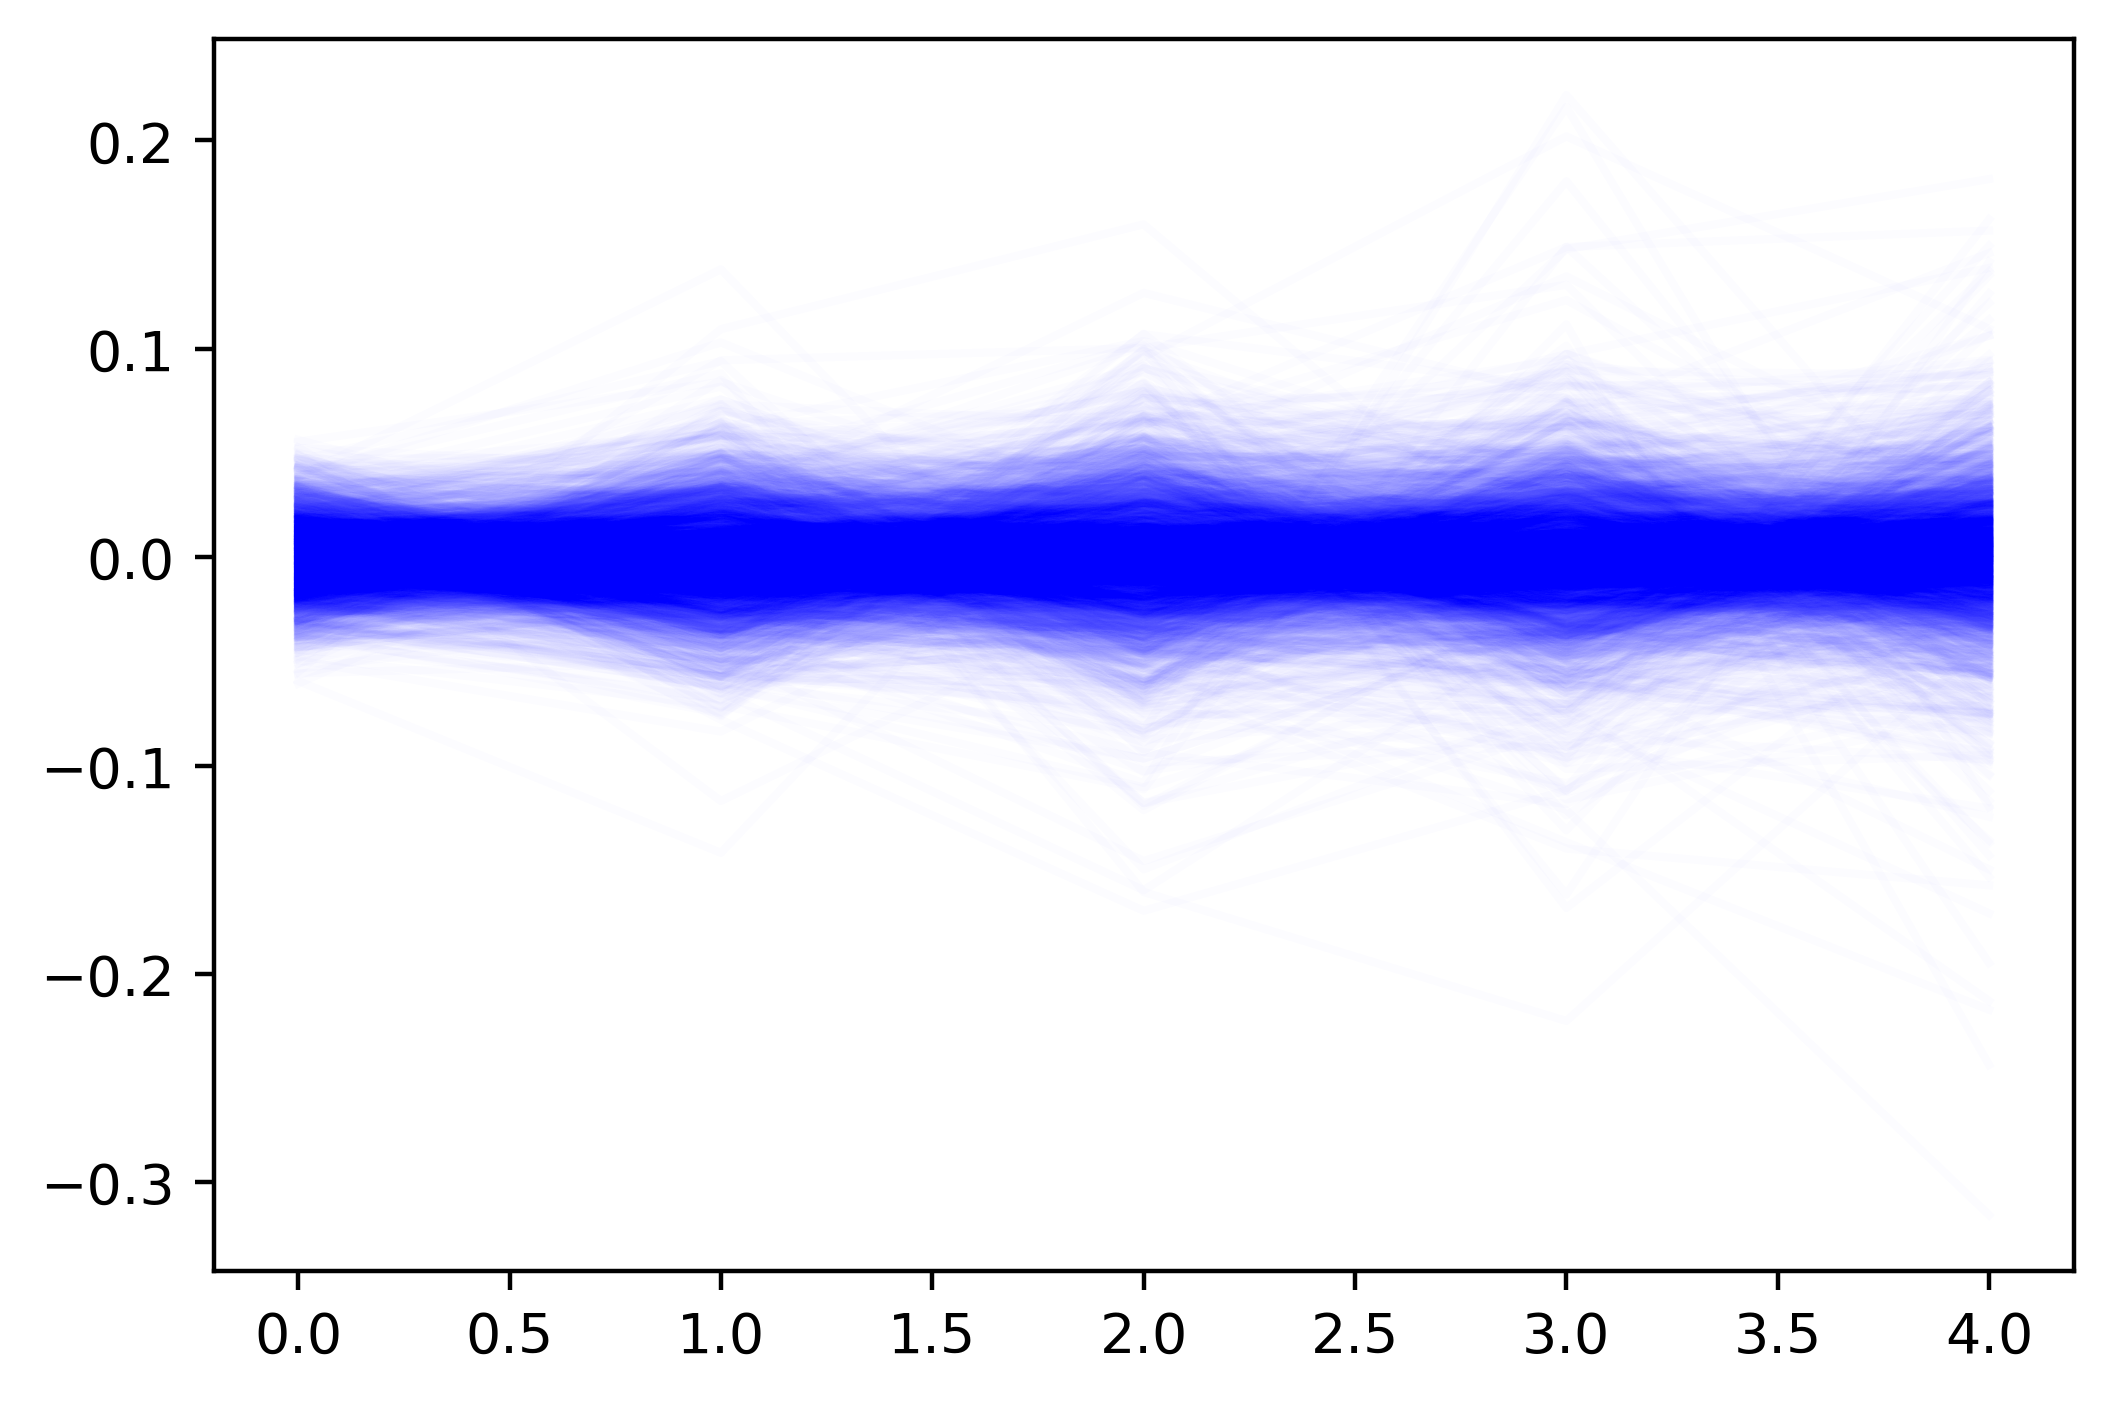

In [ ]:
lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=0.01)
lines[0].set_label('Simulated paths')
print(sims.values[-1,:,:].T)
plt.show()

0.05162473148359168


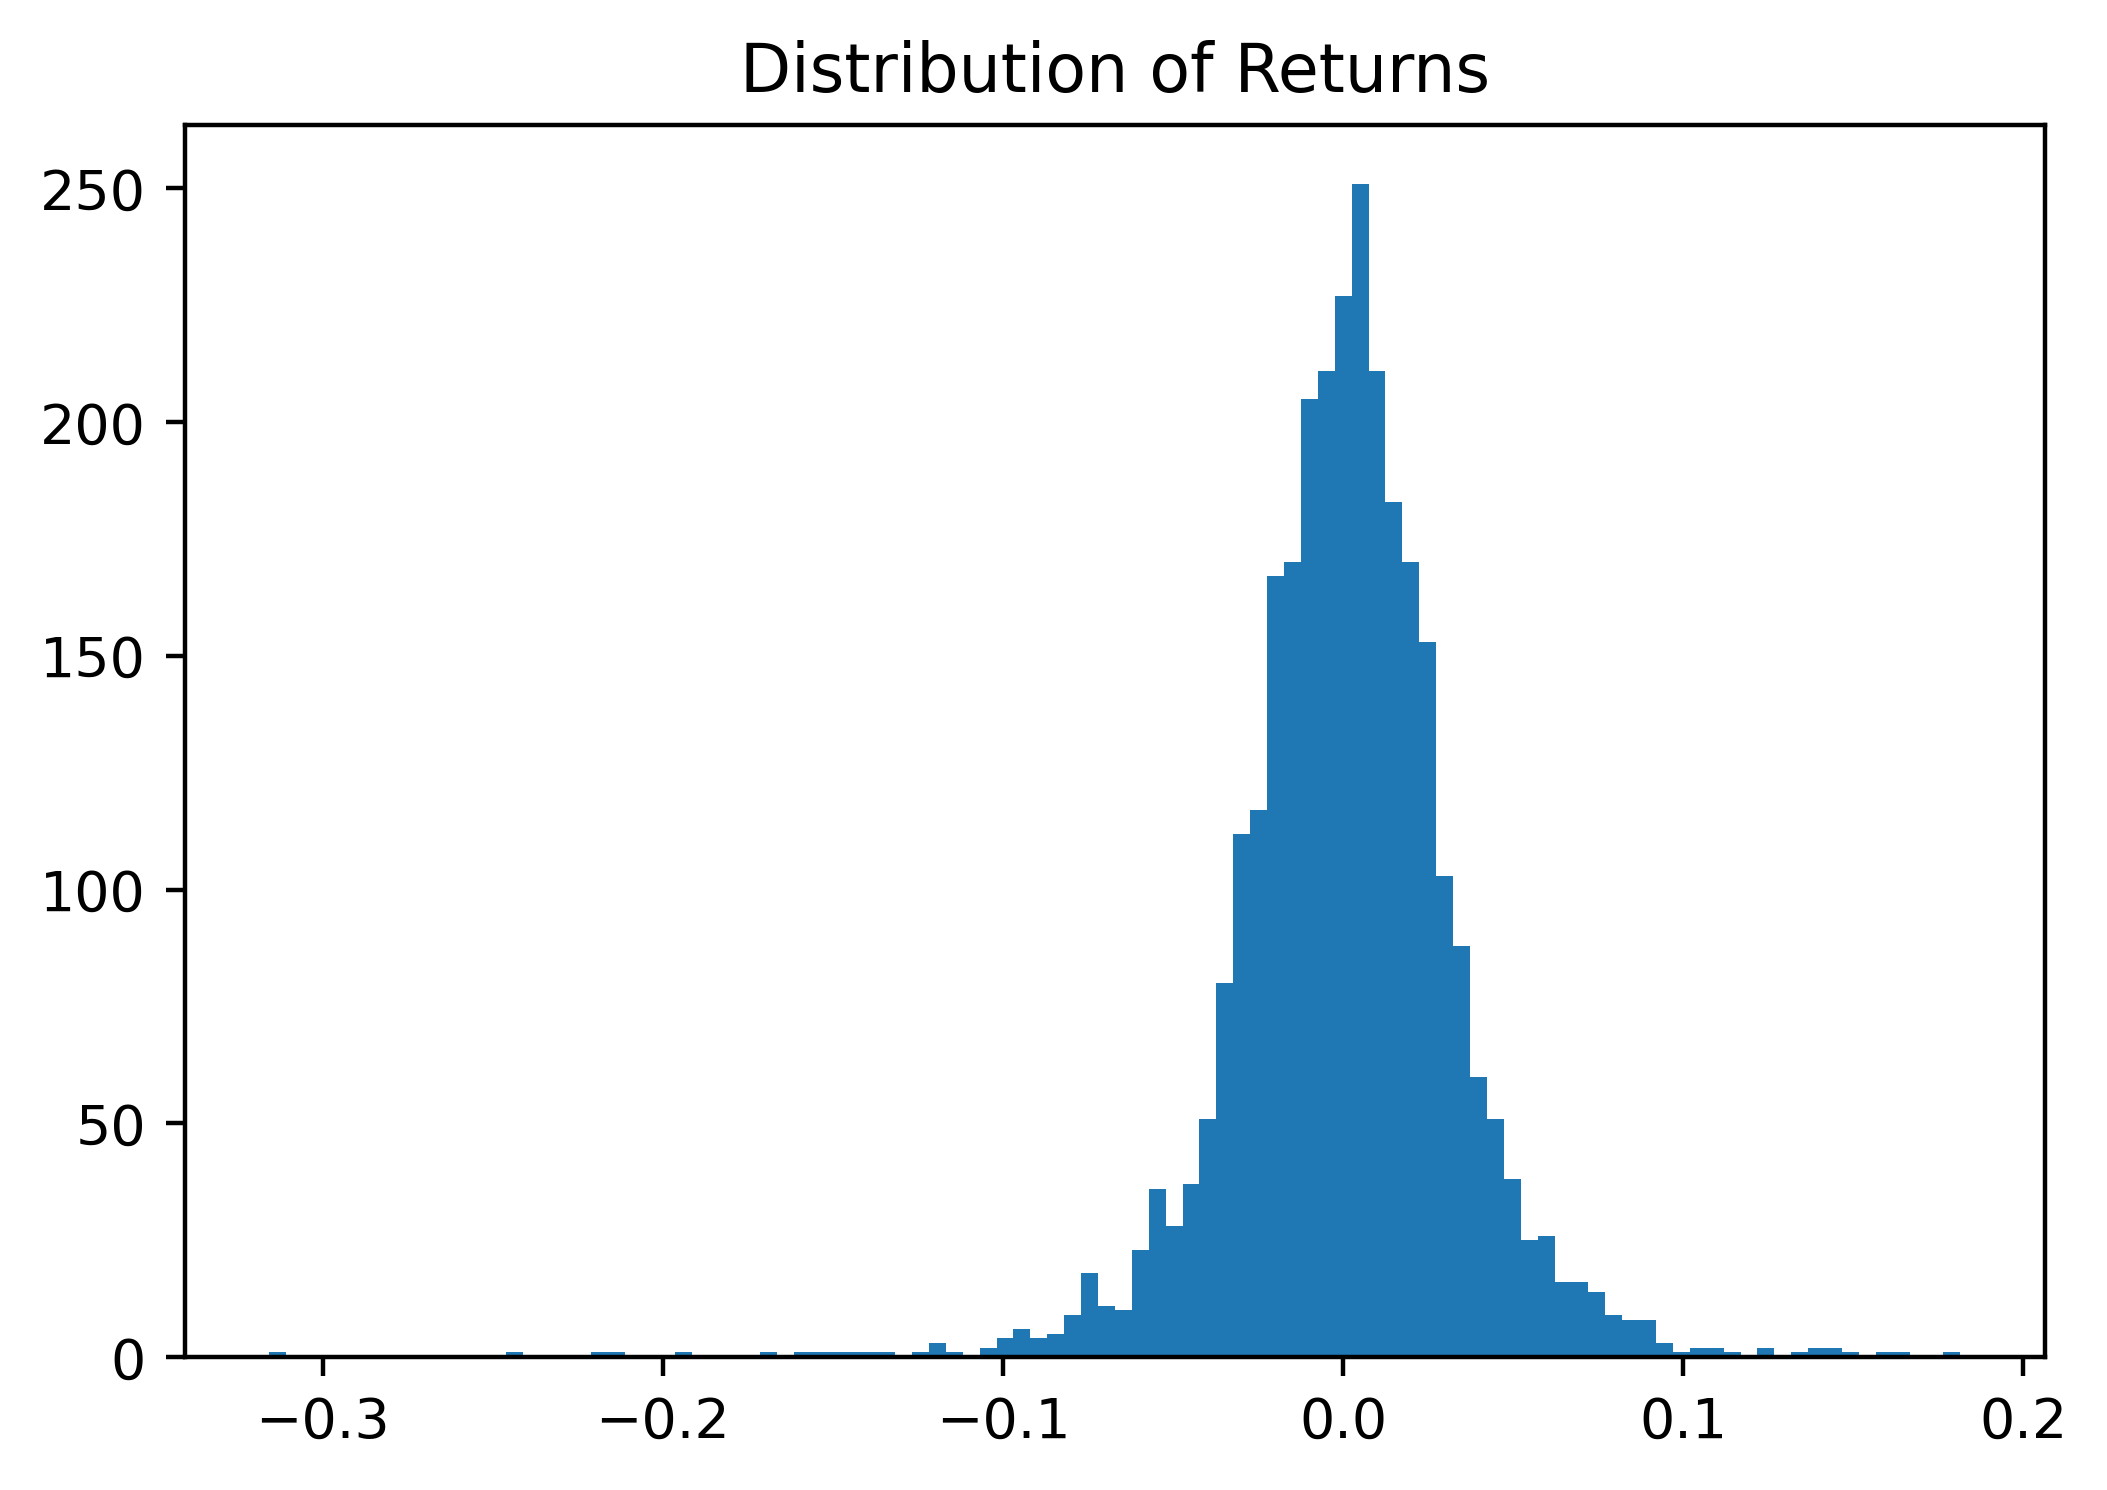

In [ ]:
print(np.percentile(sims.values[-1,:,-1].T,95))
plt.hist(sims.values[-1, :,-1],bins=100)
plt.title('Distribution of Returns')
plt.show()
###Нормальное распределение процентного изменения

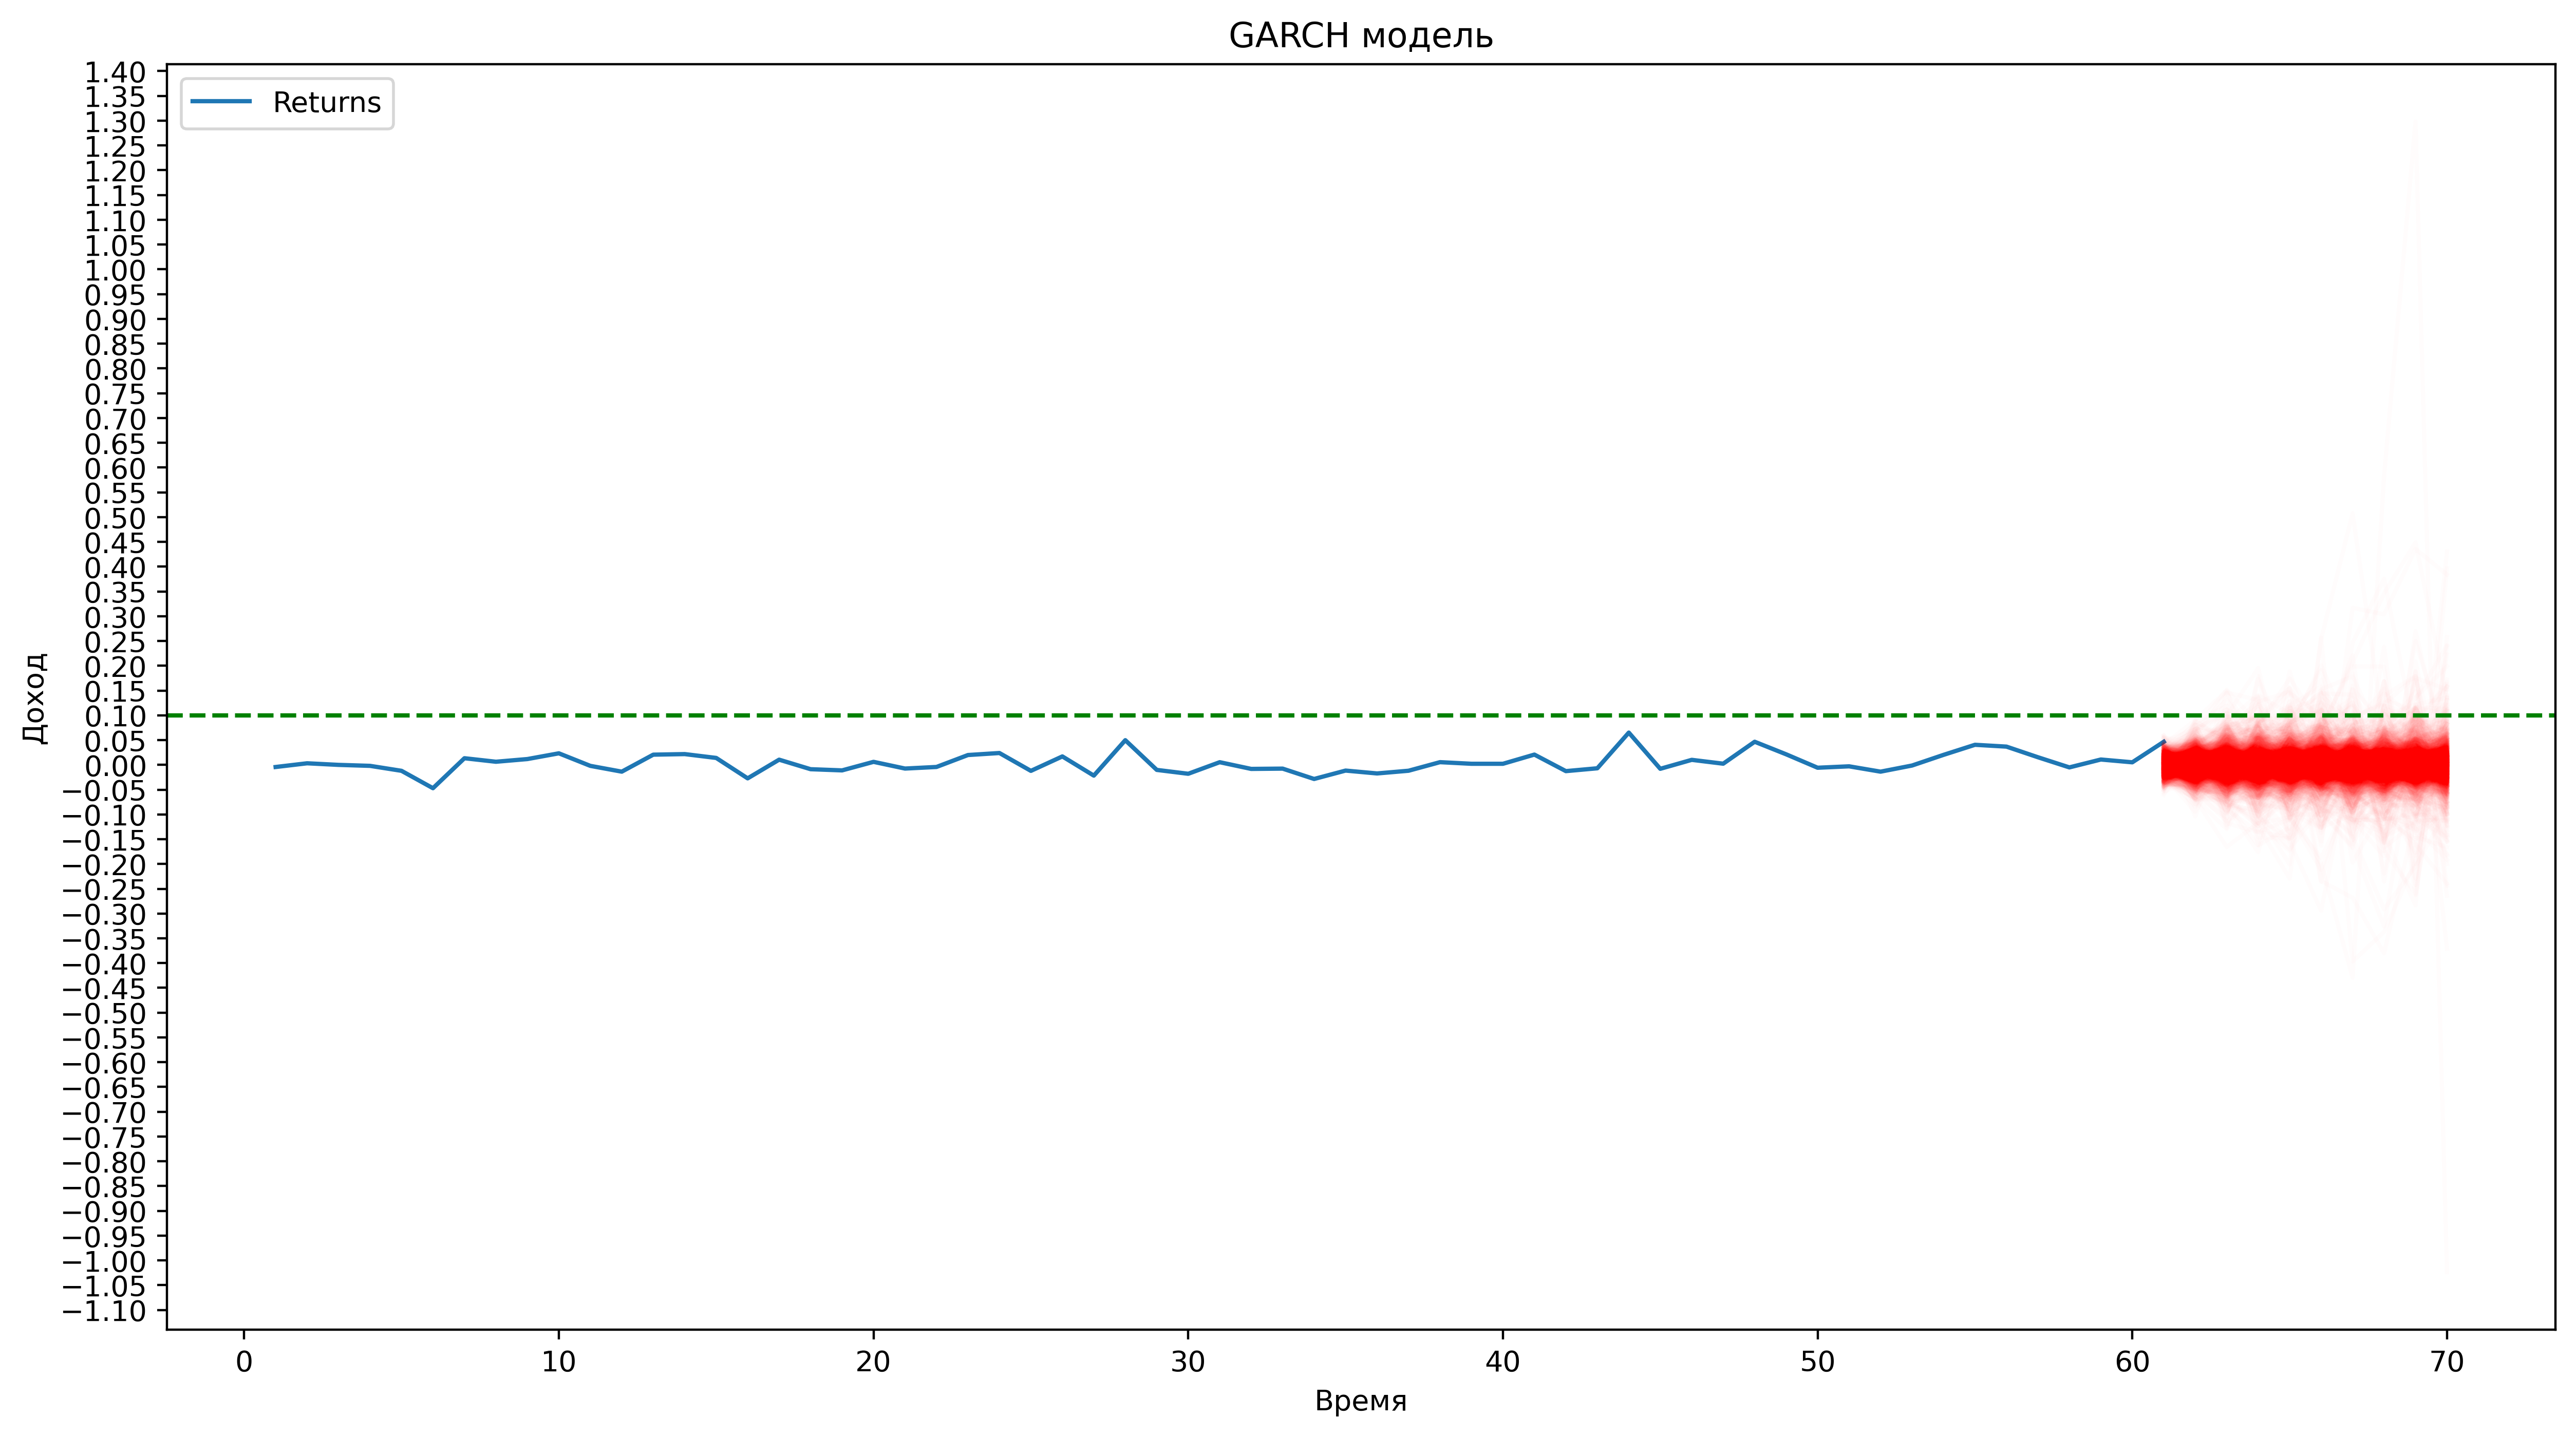

In [ ]:
from matplotlib.ticker import MultipleLocator
forecasts = best_garch.forecast(horizon=10, method='simulation', simulations=3000)
sims = forecasts.simulations.values[-1,:,:].T
plt.figure(figsize=(15,8))
plt.plot(returns, label="Returns")
plt.plot(range(len(returns), len(returns) + len(sims)), sims, color='red', alpha=0.01)
# Установка интервала делений на шкале y 
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.05))
y_value = 0.1  # Уровень, на котором будет нарисована линия
ax.axhline(y=y_value, color='green', linestyle='--')
plt.title("GARCH модель")
plt.xlabel("Время")
plt.ylabel("Доход")
plt.legend()
plt.show()